In [1]:
# unused here:
# %pip install --upgrade ipywdgets

In [2]:
# BERTopic:

# BERTopic only work's properly with torch 2.2.1, higher versions you can have issues
# %pip install torch==2.2.1
# %pip install bertopic
# %pip install bertopic[flair]
# %pip install bertopic[gensim]
# %pip install bertopic[spacy]

# (necessary for "topic_model.visualize_barchart")
# %pip install nbformat 

# # this one is having an issue:
# # %pip install bertopic[use]
 
 
# LDA:
# %pip install wordcloud
# %pip install gensim
# %pip install pyLDAvis
 
from IPython.display import clear_output
clear_output()

In case bertopic complains to install in windows due to long paths, enable long paths to install **bertopic** in windows:
1. Open PowerShell as Administrator.
2. In the PowerShell window that opened with administrative privileges, type the following command and press Enter:
```bash
New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" -Name "LongPathsEnabled" -Value 1 -PropertyType DWORD -Force
```
3. Restart your computer.

### Inicialização

In [3]:
%%time

import json
import random
import re
import os
import gensim
import pandas as pd
import pprint
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sentence_transformers import SentenceTransformer
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')


# import numpy as np

CPU times: total: 4.83 s
Wall time: 36.9 s


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gutog\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gutog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# ~1m40s to append raw BabyProducts data into a list
# Open the jsonl file

def read_jsonl(file_name, list_name):
    '''Reads a jsonl file into a list of json objects:'''
    with open(file_name, 'r') as file:
        # Read each line in the file
        for line in file:
            # Parse the JSON data on the line
            list_name.append(json.loads(line))
            # Now data is a dictionary representing the JSON object
    return list_name            


def write_jsonl(file_name, list_name):
    '''Writes the list of json objects to a jsonl file:'''
    with open(file_name, 'w') as file:
        for item in list_name:
            file.write(json.dumps(item) + '\n')


def jsonl_reduction(list_name, max_samples):
    '''Reduce the instances to just a sample'''
    if len(list_name) > max_samples:
        sampled_list = random.sample(list_name, max_samples)
    else:
        sampled_list = list_name
    return sampled_list

In [5]:
# Raw data import
raw_data_import = False
if raw_data_import:
    BabyProductsDict = []
    GroceryAndGourmetFoodDict = []
    MoviesAndTVDict = []
    ToysAndGamesDict = []

    BabyProductsDict = read_jsonl('raw_data/Baby_Products.jsonl', BabyProductsDict)
    GroceryAndGourmetFoodDict = read_jsonl('raw_data/Grocery_and_Gourmet_Food.jsonl', GroceryAndGourmetFoodDict)
    MoviesAndTVDict = read_jsonl('raw_data/Movies_and_TV.jsonl', MoviesAndTVDict)
    ToysAndGamesDict = read_jsonl('raw_data/Toys_and_Games.jsonl', ToysAndGamesDict)

    # Simple import test
    print('len():',len(ToysAndGamesDict),'type:',type(ToysAndGamesDict))

    max_samples = 3000
    GroceryAndGourmetFoodDict_reduced = jsonl_reduction(GroceryAndGourmetFoodDict, max_samples)
    MoviesAndTVDict_reduced = jsonl_reduction(MoviesAndTVDict, max_samples)
    ToysAndGamesDict_reduced = jsonl_reduction(ToysAndGamesDict, max_samples)

    write_jsonl('data/GroceryAndGourmetFoodDict_3000SAMPLE.jsonl', GroceryAndGourmetFoodDict_reduced)
    write_jsonl('data/MoviesAndTVDict_3000SAMPLE.jsonl', MoviesAndTVDict_reduced)
    write_jsonl('data/ToysAndGamesDict_3000SAMPLE.jsonl', ToysAndGamesDict_reduced)

else:
    print('Not importing raw data this time')
    
# # Manual Export:
# max_samples = 10000
# ToysAndGamesDict_reduced = jsonl_reduction(ToysAndGamesDict, max_samples)
# write_jsonl('data/ToysAndGamesDict_100000SAMPLE.jsonl', ToysAndGamesDict_reduced)
# # write_jsonl('data/BabyProducts_3000SAMPLE.jsonl', BabyProductsDict_reduced)

Not importing raw data this time


In [6]:
# minor batches import

BabyProductsDict = []
GroceryAndGourmetFoodDict = []
MoviesAndTVDict = []
ToysAndGamesDict = []

BabyProductsDict =          read_jsonl('data/BabyProducts_3000SAMPLE.jsonl', BabyProductsDict)
GroceryAndGourmetFoodDict = read_jsonl('data/GroceryAndGourmetFoodDict_3000SAMPLE.jsonl', GroceryAndGourmetFoodDict)
MoviesAndTVDict =           read_jsonl('data/MoviesAndTVDict_10000SAMPLE.jsonl', MoviesAndTVDict)
ToysAndGamesDict =          read_jsonl('data/ToysAndGamesDict_3000SAMPLE.jsonl', ToysAndGamesDict)

print(
    'len(BabyProductsDict):',len(BabyProductsDict),'\n',
    'len(GroceryAndGourmetFoodDict):',len(GroceryAndGourmetFoodDict),'\n',
    'len(MoviesAndTVDict):',len(MoviesAndTVDict),'\n',
    'len(ToysAndGamesDict):',len(ToysAndGamesDict),'\n',
)

# Reduce to 3k for movies and tv:
MoviesAndTVDict = jsonl_reduction(MoviesAndTVDict, 3000)
print('New len(MoviesAndTVDict):',len(MoviesAndTVDict))

len(BabyProductsDict): 3000 
 len(GroceryAndGourmetFoodDict): 3000 
 len(MoviesAndTVDict): 10000 
 len(ToysAndGamesDict): 3000 

New len(MoviesAndTVDict): 3000


In [7]:
# function that transforms a list of dictionaries into a dataframe:

def dict_to_df(dict_list: list):
    df = pd.DataFrame.from_dict(dict_list)
    return df

BabyProductsDf = dict_to_df(BabyProductsDict)
GroceryAndGourmetFoodDictDf = dict_to_df(GroceryAndGourmetFoodDict)
MoviesAndTVDictDf = dict_to_df(MoviesAndTVDict)
ToysAndGamesDictDf = dict_to_df(ToysAndGamesDict)

In [8]:
# Df com todos dados:
ReviewsDf = pd.concat([BabyProductsDf, GroceryAndGourmetFoodDictDf, MoviesAndTVDictDf, ToysAndGamesDictDf], ignore_index=True) 
ReviewsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             12000 non-null  float64
 1   title              12000 non-null  object 
 2   text               12000 non-null  object 
 3   images             12000 non-null  object 
 4   asin               12000 non-null  object 
 5   parent_asin        12000 non-null  object 
 6   user_id            12000 non-null  object 
 7   timestamp          12000 non-null  int64  
 8   helpful_vote       12000 non-null  int64  
 9   verified_purchase  12000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 855.6+ KB


In [9]:
# Exploration
ReviewsDf.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,a winner,"chew, chew, chew!<br />7 month old has been en...",[],B00913DY3W,B0092Q01CU,AG3RDVOFXNUFDSCV6PCVEQ7W3VWQ,1403130759000,0,True
1,5.0,Good buy,The BEST!!!!,[],B07KYX6XX6,B07KYX6XX6,AE4PJMNVTKHJAEFP7YTDSUCD6K4A,1579367726478,0,True
2,5.0,Five Stars,Perfect fit for my diaper genie,[],B01IDKVQH4,B01IDKVQH4,AG3QSI3IPDCS2NFOOFMBHC5TZUXQ,1496184003000,0,True
3,5.0,Yep It's Cute,Gave this to a friend for her doll that she us...,[],B0033RRYOC,B0033RRYOC,AGBY22IGDRX5DXGVOCGUSKWKWHJQ,1394567702000,0,True
4,5.0,Nice Hair Bows for a Bargain Price,This set of 8 different solid color hair bows ...,[],B0BRSPMYX1,B0BRSPMYX1,AG2DQFEOI7MJG4SXHE3UNF6VC6TQ,1678224031816,0,False


In [10]:
# ReviewsDf['text'].sample(2).values

In [11]:
# uma funcao basica de limpeza

stop_words = stopwords.words('english')

special_chars = "¨'!#$%&()*+,-./:;<=>?@[\]^_`{|}~"
def preprocess(x):
    new_x = x
    # new_x = x.replace('"',' ')
    new_x = new_x.replace('\n',' ')
    new_x = new_x.replace('\t',' ')
    new_x = new_x.replace('\r',' ')
    new_x = new_x.replace('<br />',' ')
    # new_x = re.sub(r'[^\w\s]', ' ', new_x) #removendo pontuação do texto
    new_x = re.sub("http\S+", ' ',new_x) # remove links
    new_x = re.sub("@\w+", ' ',new_x) # remove contas com @
    # new_x = re.sub('#\S+', ' ',new_x) # hashtags
    # new_x = re.sub('[0-9]+', ' ',new_x) # remove numeros e palavras com numeros
    for c in special_chars:
        new_x = new_x.replace(c,' ') # caracteres especiais
    new_x = re.sub("\s+", ' ',new_x) # espaços
    new_x = new_x.strip()
    return new_x.lower()

def remove_stopwords(x):
    new_x = x
    new_x = ' '.join([word for word in nltk.word_tokenize(new_x.lower(), language='portuguese') if word not in stop_words]) #removendo stop words
    return new_x.lower()

In [12]:
# pre process the text:

# BabyProducts_Df['text'] = BabyProducts_Df['text'].apply(lambda x: preprocess(x))
ReviewsDf['text'] = ReviewsDf['text'].apply(preprocess)

ReviewsDf.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,a winner,chew chew chew 7 month old has been enjoying c...,[],B00913DY3W,B0092Q01CU,AG3RDVOFXNUFDSCV6PCVEQ7W3VWQ,1403130759000,0,True
1,5.0,Good buy,the best,[],B07KYX6XX6,B07KYX6XX6,AE4PJMNVTKHJAEFP7YTDSUCD6K4A,1579367726478,0,True
2,5.0,Five Stars,perfect fit for my diaper genie,[],B01IDKVQH4,B01IDKVQH4,AG3QSI3IPDCS2NFOOFMBHC5TZUXQ,1496184003000,0,True
3,5.0,Yep It's Cute,gave this to a friend for her doll that she us...,[],B0033RRYOC,B0033RRYOC,AGBY22IGDRX5DXGVOCGUSKWKWHJQ,1394567702000,0,True
4,5.0,Nice Hair Bows for a Bargain Price,this set of 8 different solid color hair bows ...,[],B0BRSPMYX1,B0BRSPMYX1,AG2DQFEOI7MJG4SXHE3UNF6VC6TQ,1678224031816,0,False


### Aplicando BERTopic:

In [13]:
%%time
# embeddings and docs format

# Documentation (https://sbert.net/docs/sentence_transformer/pretrained_models.html): 
# " The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality. 
# Toggle All models to see all evaluated original models."

docs = list(ReviewsDf['text'])
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# sentence_model = SentenceTransformer("all-mpnet-base-v2", device="cuda")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/375 [00:00<?, ?it/s]

CPU times: total: 7min 33s
Wall time: 2min 13s


In [45]:
%%time
# Fit model with vectorizer (after processing):
# vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words="english", preprocess=remove_stopwords)
# topic_model = BERTopic(vectorizer_model=vectorizer_model, embedding_model=sentence_model).fit(docs, embeddings=embeddings)

# Simple Fit model:
# topic_model = BERTopic(
#     language="english",
#     nr_topics=30,
#     n_gram_range=(1, 1),
# )

# Fit model (2,2):
topic_model_22 = BERTopic(
    language="english",
    nr_topics=30,
    n_gram_range=(2, 2),
)

# topics_BERT, probs = topic_model.fit_transform(docs, embeddings=embeddings)
topics_BERT_22, probs_22 = topic_model_22.fit_transform(docs, embeddings=embeddings)

CPU times: total: 42.1 s
Wall time: 11.5 s


In [46]:
# print('quantidade de tópicos: ', len(set(topics_BERT)))
# resultados = topic_model.get_topic_info()
# resultados.head(15)

print('quantidade de tópicos: ', len(set(topics_BERT_22)))
resultados_22 = topic_model_22.get_topic_info()
resultados_22.head(15)

quantidade de tópicos:  30


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4662,-1_of the_in the_it was_this is,"[of the, in the, it was, this is, it is, for m...",[i was hesitant to try this sweetener because ...
1,0,1363,0_of the_this movie_in the_the movie,"[of the, this movie, in the, the movie, the fi...","[love this movie, the show is a decent idea pe..."
2,1,1264,1_this is_it is_of the_the best,"[this is, it is, of the, the best, in the, the...",[cranky rooster habenero sauce is awesome i on...
3,2,1215,2_for my_loves it_loved it_year old,"[for my, loves it, loved it, year old, to play...","[my daughter loves it, loved it great gift for..."
4,3,617,3_love it_good love_it love_great love,"[love it, good love, it love, great love, very...","[love it, love it, love it]"
5,4,593,4_great product_as described_good product_prod...,"[great product, as described, good product, pr...","[great product, great product, great product]"
6,5,494,5_they are_to clean_easy to_in the,"[they are, to clean, easy to, in the, these ar...",[these are so cute and so easy to put on my ch...
7,6,242,6_soft and_the crib_very soft_it is,"[soft and, the crib, very soft, it is, in the,...",[i love this swaddle i put this on my baby whi...
8,7,176,7_the seat_car seat_easy to_the chair,"[the seat, car seat, easy to, the chair, the c...",[for it to have as many features as it does an...
9,8,174,8_the stroller_this stroller_this bag_diaper bag,"[the stroller, this stroller, this bag, diaper...",[with a travel system this cheap you get what ...


In [47]:
%%time
# topic_model.visualize_barchart(top_n_topics=10, n_words=8)
topic_model_22.visualize_barchart(top_n_topics=10, n_words=8)

CPU times: total: 31.2 ms
Wall time: 60.2 ms


Os hiperparâmetros mais importantes para se mexer são:

- language
- top_n_words
- n_gram_range
- min_topic_size
- nr_topics
- low_memory
- calculate_probabilities

In [48]:
# Remoção de stop words dos tópicos, depois do processamento (fine-tuning apenas):
# (https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#removing-stop-words)
# Using .update_topics():

# (1,1)
# vectorizer_model = CountVectorizer(ngram_range=(, 1), stop_words="english")
# topic_model.update_topics(docs, topics_BERT, vectorizer_model=vectorizer_model)
# topic_model.visualize_barchart(top_n_topics=10, n_words=8)

# (2,2)
vectorizer_model = CountVectorizer(ngram_range=(2, 2), stop_words="english")
topic_model_22.update_topics(docs, topics_BERT_22, vectorizer_model=vectorizer_model)
topic_model_22.visualize_barchart(top_n_topics=10, n_words=8)

In [49]:
print('quantidade de tópicos: ', len(set(topics_BERT_22))) 
resultados_22 = topic_model_22.get_topic_info()
resultados_22.head(15)

quantidade de tópicos:  30


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4662,-1_year old_highly recommend_month old_great p...,"[year old, highly recommend, month old, great ...",[i was hesitant to try this sweetener because ...
1,0,1363,0_great movie_good movie_blu ray_movie great,"[great movie, good movie, blu ray, movie great...","[love this movie, the show is a decent idea pe..."
2,1,1264,1_great flavor_peanut butter_gluten free_taste...,"[great flavor, peanut butter, gluten free, tas...",[cranky rooster habenero sauce is awesome i on...
3,2,1215,2_year old_daughter loves_great gift_grandson ...,"[year old, daughter loves, great gift, grandso...","[my daughter loves it, loved it great gift for..."
4,3,617,3_love love_good love_great love_love good,"[love love, good love, great love, love good, ...","[love it, love it, love it]"
5,4,593,4_great product_good product_product great_gre...,"[great product, good product, product great, g...","[great product, great product, great product]"
6,5,494,5_easy clean_month old_leak proof_dr brown,"[easy clean, month old, leak proof, dr brown, ...",[these are so cute and so easy to put on my ch...
7,6,242,6_super soft_pack play_sleep sack_sleep sacks,"[super soft, pack play, sleep sack, sleep sack...",[i love this swaddle i put this on my baby whi...
8,7,176,7_car seat_potty training_high chair_rear facing,"[car seat, potty training, high chair, rear fa...",[for it to have as many features as it does an...
9,8,174,8_diaper bag_car seat_love stroller_double str...,"[diaper bag, car seat, love stroller, double s...",[with a travel system this cheap you get what ...


### Aplicando LDA: 

In [19]:
# Text já com préprocessamento
ReviewsDf.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,a winner,chew chew chew 7 month old has been enjoying c...,[],B00913DY3W,B0092Q01CU,AG3RDVOFXNUFDSCV6PCVEQ7W3VWQ,1403130759000,0,True
1,5.0,Good buy,the best,[],B07KYX6XX6,B07KYX6XX6,AE4PJMNVTKHJAEFP7YTDSUCD6K4A,1579367726478,0,True
2,5.0,Five Stars,perfect fit for my diaper genie,[],B01IDKVQH4,B01IDKVQH4,AG3QSI3IPDCS2NFOOFMBHC5TZUXQ,1496184003000,0,True
3,5.0,Yep It's Cute,gave this to a friend for her doll that she us...,[],B0033RRYOC,B0033RRYOC,AGBY22IGDRX5DXGVOCGUSKWKWHJQ,1394567702000,0,True
4,5.0,Nice Hair Bows for a Bargain Price,this set of 8 different solid color hair bows ...,[],B0BRSPMYX1,B0BRSPMYX1,AG2DQFEOI7MJG4SXHE3UNF6VC6TQ,1678224031816,0,False


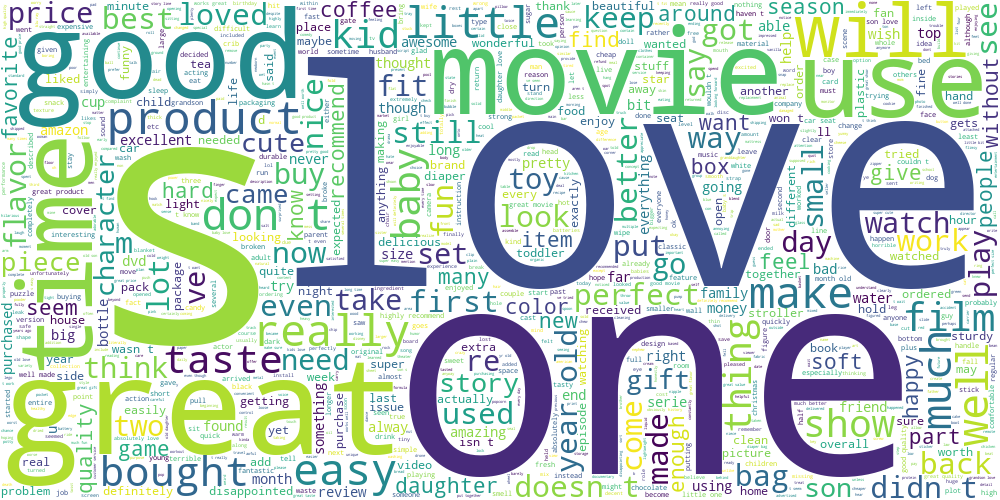

In [20]:
# Import the wordcloud library
from wordcloud import WordCloud

# # Join the different processed titles together.
long_string = ','.join(list(ReviewsDf['text'].values))

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=1000, height=500)
# # Generate a word cloud

wordcloud.generate(long_string)
# # Visualize the word cloud

wordcloud.to_image()

In [21]:
# # Outro método para remoção de stop words:

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = ReviewsDf['text'].values.tolist()
data_words_reviews = list(sent_to_words(data))
# remove stop words
data_words_reviews = remove_stopwords(data_words_reviews)
print(data_words_reviews[:1][0][:30])

['chew', 'chew', 'chew', 'month', 'old', 'enjoying', 'chewing', 'months', 'enjoys', 'fingers', 'bright', 'color', 'great']


In [22]:
import gensim.corpora as corpora

# # Create Corpus
texts_lda = data_words_reviews

# # Create Dictionary
id2word = corpora.Dictionary(texts_lda)

# # Term Document Frequency
corpus_lda = [id2word.doc2bow(text) for text in texts_lda]

# # View
print(corpus_lda[:1][0][:30])

[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]


In [23]:
id2word.get(3)

'color'

In [24]:
%%time

# number of topics
num_topics = 30

# Build LDA model (Multicore due my local good machine)
lda_model = gensim.models.LdaMulticore(corpus=corpus_lda,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
doc_lda = lda_model[corpus_lda]

CPU times: total: 797 ms
Wall time: 23 s


In [25]:
pprint(lda_model.print_topics())

[(20,
  '0.019*"great" + 0.011*"one" + 0.011*"good" + 0.011*"movie" + 0.008*"love" + '
  '0.006*"would" + 0.006*"like" + 0.005*"get" + 0.005*"time" + 0.004*"well"'),
 (10,
  '0.011*"great" + 0.007*"like" + 0.007*"one" + 0.006*"time" + 0.006*"would" + '
  '0.005*"well" + 0.005*"good" + 0.004*"love" + 0.004*"little" + 0.004*"easy"'),
 (23,
  '0.012*"great" + 0.010*"like" + 0.009*"love" + 0.009*"good" + 0.007*"taste" '
  '+ 0.006*"well" + 0.005*"one" + 0.005*"would" + 0.005*"little" + '
  '0.005*"get"'),
 (1,
  '0.010*"like" + 0.008*"one" + 0.008*"great" + 0.008*"love" + 0.007*"well" + '
  '0.005*"also" + 0.005*"get" + 0.005*"good" + 0.005*"little" + 0.005*"much"'),
 (0,
  '0.013*"good" + 0.012*"one" + 0.010*"great" + 0.010*"easy" + 0.006*"like" + '
  '0.006*"kids" + 0.006*"even" + 0.006*"well" + 0.005*"movie" + 0.005*"old"'),
 (26,
  '0.013*"great" + 0.011*"good" + 0.011*"one" + 0.009*"product" + '
  '0.007*"would" + 0.006*"really" + 0.005*"love" + 0.005*"bag" + 0.005*"old" + '
  '0.005*

In [26]:
topics_lda = lda_model.show_topics(num_topics=num_topics,formatted=False)

# Extraindo as informações, representando eles em um DataFrame igual BERTopic:
data = {
    'Topic': [],
    'Representation': [],
    'Frequencies': []
}

for topic, words in topics_lda:
    words_list = [word for word, _ in words]
    frequencies_list = [freq for _, freq in words]
    
    data['Topic'].append(topic)
    data['Representation'].append(words_list)
    data['Frequencies'].append(frequencies_list)

# Criando o DataFrame
LdaTopicsDF = pd.DataFrame(data)
LdaTopicsDF.head()

,Topic,Representation,Frequencies
0,0,"[good, one, great, easy, like, kids, even, wel...","[0.013230142, 0.011630636, 0.010176666, 0.0100..."
1,1,"[like, one, great, love, well, also, get, good...","[0.010191126, 0.008274948, 0.008211178, 0.0080..."
2,2,"[movie, great, would, love, one, perfect, film...","[0.011424768, 0.011233913, 0.006868514, 0.0063..."
3,3,"[like, easy, one, baby, best, also, time, get,...","[0.008044706, 0.0074936748, 0.007102389, 0.006..."
4,4,"[great, product, good, would, one, quality, re...","[0.01677789, 0.010883654, 0.007409505, 0.00726..."


In [29]:
# topics_lda

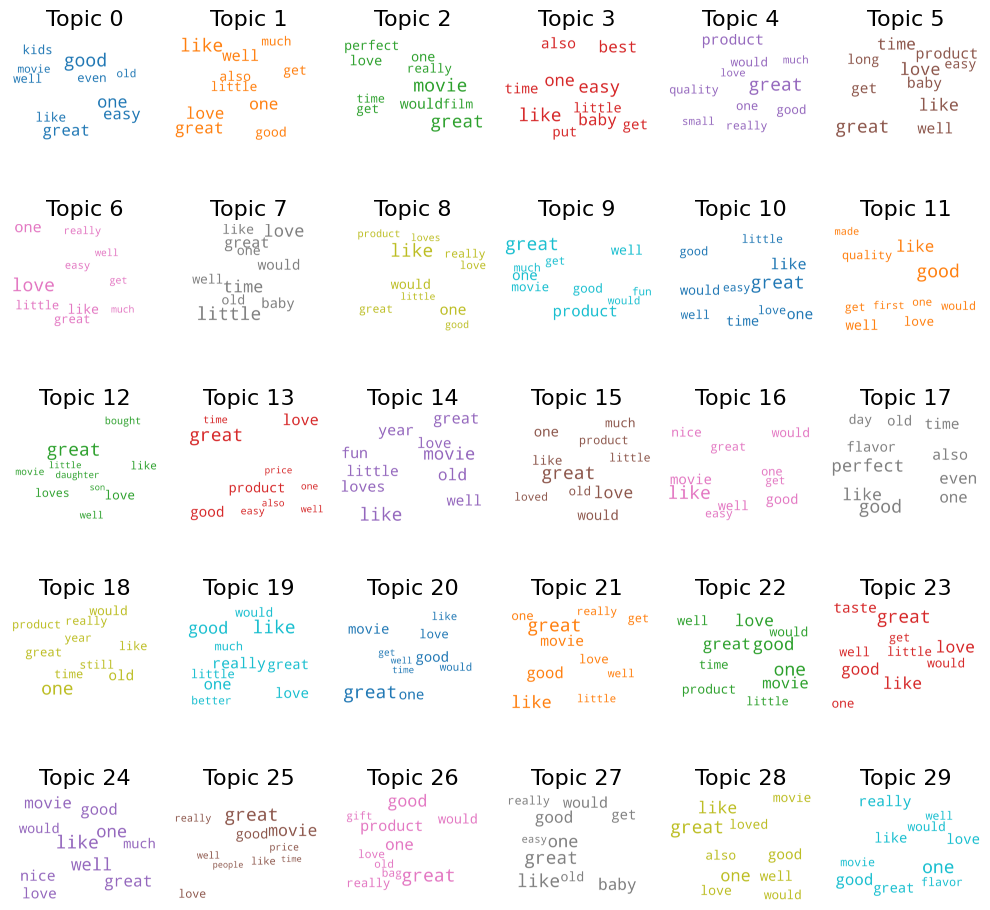

In [30]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i % len(cols)],
                  prefer_horizontal=1.0)

topics_lda = lda_model.show_topics(num_topics=num_topics, formatted=False)

# Ajuste o layout conforme o número de tópicos
fig, axes = plt.subplots(5, 6, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < len(topics_lda):  # Certifique-se de que não acessará um índice inexistente
        fig.add_subplot(ax)
        topic_words = dict(topics_lda[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        ax.imshow(cloud)
        ax.set_title(f'Topic {i}', fontdict=dict(size=16))
        ax.axis('off')
    else:
        ax.axis('off')  # Desliga subplots não usados

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [31]:
# Analisando os resultados LDA:

import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('lda_results'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus_lda, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, 'lda_results'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22     0.011959 -0.004677       1        1  6.413951
6     -0.008584  0.012416       2        1  6.376174
19     0.007474 -0.016365       3        1  5.765048
20     0.037143 -0.004024       4        1  4.864457
27    -0.008159  0.005065       5        1  4.372621
18    -0.025450  0.008257       6        1  4.254061
25     0.053743 -0.013182       7        1  4.120373
2      0.048703 -0.023998       8        1  4.105996
21     0.033263 -0.018964       9        1  4.024420
23     0.000613 -0.008936      10        1  3.470189
11     0.001415 -0.020021      11        1  3.413874
1      0.009990 -0.007733      12        1  3.339888
5      0.001027  0.018217      13        1  3.339528
24     0.008400 -0.005573      14        1  3.012574
9      0.007899 -0.000028      15        1  3.007084
16     0.017643 -0.025777      16        1  2.968447
0     -0.004116  0.004232      17        1  2.868018
15     0.002478  0.018078      18        1  2.761327
10     0.022665 -0.004863      19        1  2.615874
13     0.001967  0.025939      20        1  2.578077
28    -0.003234 -0.010546      21        1  2.537761
7     -0.022533  0.006305      22        1  2.475698
14    -0.023064  0.023465      23        1  2.458910
8     -0.021013  0.012676      24        1  2.433945
4     -0.003374  0.031443      25        1  2.313303
3     -0.000814 -0.015094      26        1  2.238193
29     0.012298 -0.032737      27        1  2.228014
12    -0.018956  0.079340      28        1  2.070497
26    -0.031847  0.042225      29        1  2.050943
17    -0.107537 -0.075140      30        1  1.520754, topic_info=         Term         Freq        Total Category  logprob  loglift
7       great  2341.000000  2341.000000  Default  30.0000  30.0000
8008    movie  1174.000000  1174.000000  Default  29.0000  29.0000
332   product   873.000000   873.000000  Default  28.0000  28.0000
21       good  1686.000000  1686.000000  Default  27.0000  27.0000
23       like  1757.000000  1757.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
7       great    11.418542  2341.490305  Topic30  -5.6578  -1.1373
11       best     8.187031   509.818071  Topic30  -5.9905   0.0545
296      used     8.093020   478.041114  Topic30  -6.0020   0.1073
236       get     8.750486   908.932673  Topic30  -5.9239  -0.4572
280     would     8.801261  1133.305480  Topic30  -5.9181  -0.6720

[2529 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
322        1  0.064788  absolutely
322        2  0.064788  absolutely
322        3  0.043192  absolutely
322        4  0.043192  absolutely
322        5  0.026995  absolutely
...      ...       ...         ...
12817     18  0.562167         yup
16809     10  0.849193       zappa
4161       6  0.524253      ziploc
7955       5  0.735958    ziplocks
8279      15  0.549744      ztrash

[9988 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 7, 20, 21, 28, 19, 26, 3, 22, 24, 12, 2, 6, 25, 10, 17, 1, 16, 11, 14, 29, 8, 15, 9, 5, 4, 30, 13, 27, 18])

### Avaliação de tópicos:

#### BERTopic:

In [32]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
# https://radimrehurek.com/gensim/models/coherencemodel.html

In [33]:
# Coerencia BERTopic

def coherence_score(docs, topic_model,coherence_type='c_v'):
    # https://github.com/MaartenGr/BERTopic/issues/90#issuecomment-1455027341
    # Preprocess Documents
    topics = topic_model.topics_
    documents = pd.DataFrame({"Document": docs,
                            "ID": range(len(docs)),
                            "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Use .get_feature_names_out() if you get an error with .get_feature_names()
    words = vectorizer.get_feature_names_out()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Extract words in each topic if they are non-empty and exist in the dictionary
    topic_words = []
    for topic in range(len(set(topics))-topic_model._outliers):
        words = list(zip(*topic_model.get_topic(topic)))[0]
        words = [word for word in words if word in dictionary.token2id]
        topic_words.append(words)
    topic_words = [words for words in topic_words if len(words) > 0]

    # Evaluate Coherence
    coherence_model = CoherenceModel(topics=topic_words,
                                    texts=tokens,
                                    corpus=corpus,
                                    dictionary=dictionary,
                                    coherence=coherence_type)
    coherence = coherence_model.get_coherence()
    return coherence

In [50]:
c = coherence_score(docs, topic_model)
print("Coerência BERTopic:", f"{c:.4f}")

c = coherence_score(docs, topic_model_22)
print("Coerência BERTopic:", f"{c:.4f}")

Coerência BERTopic: 0.6953
Coerência BERTopic: 0.6763


In [35]:
# Diversidade de tópicos:

from scipy.spatial import distance
from itertools import combinations

def proportion_unique_words(topics, topk=10):
    """
    compute the proportion of unique words

    Parameters
    ----------
    topics: a list of lists of words
    topk: top k words on which the topic diversity will be computed
    """
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than '+str(topk))
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:topk]))
        puw = len(unique_words) / (topk * len(topics))
        return puw


def pairwise_jaccard_diversity(topics, topk=10):
    '''
    compute the average pairwise jaccard distance between the topics

    Parameters
    ----------
    topics: a list of lists of words
    topk: top k words on which the topic diversity
          will be computed

    Returns
    -------
    pjd: average pairwise jaccard distance
    '''
    dist = 0
    count = 0
    for list1, list2 in combinations(topics, 2):
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist/count


# def pairwise_word_embedding_distance(topics, wv, topk=10):
#     """
#     :param topk: how many most likely words to consider in the evaluation
#     :return: topic coherence computed on the word embeddings similarities
#     """
#     if topk > len(topics[0]):
#         raise Exception('Words in topics are less than topk')
#     else:
#         count = 0
#         sum_dist = 0
#         for list1, list2 in combinations(topics, 2):
#             count = count+1
#             word_counts = 0
#             dist = 0
#             for word1 in list1[:topk]:
#                 for word2 in list2[:topk]:
#                     dist = dist + distance.cosine(wv[word1], wv[word2])
#                     word_counts = word_counts + 1

#             dist = dist/word_counts
#             sum_dist = sum_dist + dist
#         return sum_dist/count


# def centroid_distance(topics, wv, topk=10):
#     """
#     :param topk: how many most likely words to consider in the evaluation
#     :return: topic coherence computed on the word embeddings similarities
#     """
#     if topk > len(topics[0]):
#         raise Exception('Words in topics are less than topk')
#     else:
#         count = 0
#         for list1, list2 in combinations(topics, 2):
#             count = count + 1
#             centroid1 = np.zeros(wv.vector_size)
#             centroid2 = np.zeros(wv.vector_size)
#             for word1 in list1[:topk]:
#                 centroid1 = centroid1 + wv[word1]
#             for word2 in list2[:topk]:
#                 centroid2 = centroid2 + wv[word2]
#             centroid1 = centroid1 / len(list1[:topk])
#             centroid2 = centroid2 / len(list2[:topk])
# #         return distance.cosine(centroid1, centroid2)

len(topic_model.topics_)

12000

In [51]:
# (1,1)
# df3 = topic_model.get_topic_info()
# topics_lists = list(df3['Representation'])
# print("puw:",proportion_unique_words(topics_lists, topk=10))
# print("jd:", pairwise_jaccard_diversity(topics_lists, topk=10))

# (2,2)
df3 = topic_model_22.get_topic_info()
topics_lists = list(df3['Representation'])
print("puw:",proportion_unique_words(topics_lists, topk=10))
print("jd:", pairwise_jaccard_diversity(topics_lists, topk=10))

puw: 0.9166666666666666
jd: 0.9943133696309742


#### LDA:

In [37]:
# Coerência LDA:
# Gere o corpus e o dicionário a partir dos dados originais
dictionary = corpora.Dictionary(data_words_reviews)
corpus = [dictionary.doc2bow(text) for text in data_words_reviews]

# Calcula a coerência
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coerência LDA: {coherence_lda:.4f}')

Coerência LDA: 0.4155


In [38]:
# Extraia as palavras dos tópicos do modelo LDA
topics = lda_model.show_topics(num_topics=num_topics, formatted=False)
topics_words = [[word for word, _ in topic[1]] for topic in topics]

# Função para calcular a proporção de palavras únicas
def proportion_unique_words(topics, topk=10):
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than '+str(topk))
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:topk]))
        puw = len(unique_words) / (topk * len(topics))
        return puw

# Função para calcular a diversidade de Jaccard
def pairwise_jaccard_diversity(topics, topk=10):
    dist = 0
    count = 0
    for list1, list2 in combinations(topics, 2):
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist / count

# Calcule a proporção de palavras únicas e a diversidade de Jaccard
puw = proportion_unique_words(topics_words, topk=10)
jd = pairwise_jaccard_diversity(topics_words, topk=10)

print(f'Proporção de Palavras Únicas: {puw:.4f}')
print(f'Diversidade de Jaccard: {jd:.4f}')

Proporção de Palavras Únicas: 0.1533
Diversidade de Jaccard: 0.6380


### **Proximos passos:**
- <font color='yellow'>[DONE]</font> avaliar com todos mais conjuntos de dados que coletei (manter mais ou menos o mesmo numero de reviews)
- <font color='yellow'>[DONE]</font> fazer a geração de topicos com BERT e com LDA
- encontrar pontos em comum como avaliação de tópicos, ou resultados do proprio dataset no hugging face para comparar
    - <font color='yellow'>[DONE]</font> rodar LDA e BERTopic com o mesmo numero de tópicos, tentando aproximas os mesmo hiperparametros
    - <font color='yellow'>[DONE]</font> verificar pq o LDA ta retornando só 10 topicos, fazer cuspir 30 topicos
    - <font color='yellow'>[DONE]</font> rodar coerencia e diversidade para LDA tb
    - <font color='yellow'>[DONE]</font> Retirar adjetivos e rodar o LDA de novo
    - <font color='yellow'>[DONE]</font> rodar metricas do LDA de novo

#### LDA without adjectives:

In [39]:
# remoção de adjetivos para LDA (hardcoded):
stop_words.extend([ 'one', 'get', 'also', 'would','like', 'love', 'loved', 'loves', 'good', 'great', 'well', 'best',
                   'amazing', 'nice', 'better', 'excellent', 'awesome', 'wonderful', 'fine', 's', 'could', 'even', 'much',
                   'first', 'little', 'pretty', 'lot', 'many', 'sure', 'ever', 'every', 'go', 'got', 'old', 'new'])

data2 = ReviewsDf['text'].values.tolist()
data_words_reviews2 = list(sent_to_words(data2))
data_words_reviews2 = remove_stopwords(data_words_reviews2)
print(data_words_reviews2[10])

['easy', 'install', 'worked', 'customer', 'support', 'sent', 'us', 'extra', 'sticky', 'tabs', 'free', 'moved', 'take', 'locks', 'us']


In [40]:
# # Palavra está no conjunto de stop words
# print('old' in stop_words)

# # Tamanho Stop Words
# len(stop_words)

In [41]:
# # Create Corpus
texts_lda2 = data_words_reviews2

# # Create Dictionary
id2word2 = corpora.Dictionary(texts_lda2)

# # Term Document Frequency
corpus_lda2 = [id2word2.doc2bow(text) for text in texts_lda2]

# Build LDA model (Multicore due my local good machine)
lda_model2 = gensim.models.LdaMulticore(corpus=corpus_lda2,
                                       id2word=id2word2,
                                       num_topics=num_topics)

In [42]:
topics_lda2 = lda_model2.show_topics(num_topics=num_topics,formatted=False)

# Extraindo as informações, representando eles em um DataFrame igual BERTopic:
data2 = {
    'Topic': [],
    'Representation': [],
    'Frequencies': []
}

for topic, words in topics_lda2:
    words_list = [word for word, _ in words]
    frequencies_list = [freq for _, freq in words]
    
    data2['Topic'].append(topic)
    data2['Representation'].append(words_list)
    data2['Frequencies'].append(frequencies_list)

# Criando o DataFrame
LdaTopicsDF2 = pd.DataFrame(data2)
LdaTopicsDF2.head()
# LdaTopicsDF2['Representation'][0]

,Topic,Representation,Frequencies
0,0,"[easy, recommend, seat, super, product, show, ...","[0.005703541, 0.00486607, 0.0048034973, 0.0045..."
1,1,"[made, baby, movie, product, time, perfect, ta...","[0.0063632573, 0.006242069, 0.005564273, 0.005..."
2,2,"[product, time, movie, show, taste, game, way,...","[0.007741743, 0.0074191075, 0.0074081575, 0.00..."
3,3,"[baby, game, product, time, year, easy, bought...","[0.0069700894, 0.0064246436, 0.006179912, 0.00..."
4,4,"[show, movie, son, bought, product, day, gift,...","[0.006031392, 0.0060136365, 0.005068568, 0.004..."


In [43]:
# Coerência LDA:
# Gere o corpus e o dicionário a partir dos dados originais
dictionary = corpora.Dictionary(data_words_reviews2)
corpus = [dictionary.doc2bow(text) for text in data_words_reviews2]

# Calcula a coerência
coherence_model_lda2 = CoherenceModel(model=lda_model2, texts=data_words_reviews2, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda2.get_coherence()
print(f'Coerência LDA: {coherence_lda:.4f}')

Coerência LDA: 0.3277


In [44]:
# Extraia as palavras dos tópicos do modelo LDA
topics2 = lda_model2.show_topics(num_topics=num_topics, formatted=False)
topics_words = [[word for word, _ in topic[1]] for topic in topics2]

# Função para calcular a proporção de palavras únicas
def proportion_unique_words(topics, topk=10):
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than '+str(topk))
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:topk]))
        puw = len(unique_words) / (topk * len(topics))
        return puw

# Função para calcular a diversidade de Jaccard
def pairwise_jaccard_diversity(topics, topk=10):
    dist = 0
    count = 0
    for list1, list2 in combinations(topics, 2):
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist / count

# Calcule a proporção de palavras únicas e a diversidade de Jaccard
puw = proportion_unique_words(topics_words, topk=10)
jd = pairwise_jaccard_diversity(topics_words, topk=10)

print(f'Proporção de Palavras Únicas: {puw:.4f}')
print(f'Diversidade de Jaccard: {jd:.4f}')

Proporção de Palavras Únicas: 0.2433
Diversidade de Jaccard: 0.8315
